In [1]:
import glmnet_python
from glmnet import glmnet

# Import relevant modules and setup for calling glmnet
%matplotlib inline

import time
import sys
import os
import re
from itertools import compress
from glob import glob
import pickle

import scipy, importlib, pprint, matplotlib.pyplot as plt, warnings
from scipy.io import loadmat

import numpy as np
from glmnet import glmnet; from glmnetPlot import glmnetPlot
from glmnetPrint import glmnetPrint; from glmnetCoef import glmnetCoef; from glmnetPredict import glmnetPredict
from cvglmnet import cvglmnet; from cvglmnetCoef import cvglmnetCoef
from cvglmnetPlot import cvglmnetPlot; from cvglmnetPredict import cvglmnetPredict

# glmnet has many deprecation warnings from using scipy.* instad of numpy.*
warnings.filterwarnings("ignore", category=DeprecationWarning) 


def plot_distributions(y, y_hat):

    fig, axs = plt.subplots(2, 4, sharey=False, sharex=False, tight_layout=True)
    fig.set_size_inches(20,10)

    for ic in range(0,8):
        idx = np.unravel_index(ic, axs.shape)
        if ic < 4:
            axs[idx].set_title("Real %s"%names[ic])
            x = y[:,ic]        
        else:
            axs[idx].set_title("Predicted %s"%names[ic-4])
            x = y_hat[:,ic-4]
        axs[idx].hist(x, bins=20)

In [11]:
# Define constants
ncores = 28 # 56
names = ['DA', '5HT', 'pH', 'NE']
# data_prefix = '/mnt/nfs/proj/in-vitro/iterate/results_014/model_style_008/training-A-RBE-97Hz/'
data_prefix = '/mnt/nfs/proj/in-vitro/iterate/results_014/model_style_008/training-B-RBE025-97Hz/'

results_prefix = '/mnt/nfs/proj/in-vitro/Leonardo/glmnet/fits/'
# good_probes = ['MMA003W01R04', 'MMA004W01R04', 'MMA013W01R04', 'MMA018W01R04', 'MMA019W01R04', 'MMA022W01R04', 'MMA023W01R04', 'MMA024W01R04', 'MMA025W01R04']
good_probes = ['MMA003W01R04', ]
filter_files = lambda x : x.find('500kohm') == -1 # only get files without the 500kohms resistor

nrecords_per_session = -1 # all
# nrecords_per_session = 1 # first
# nrecords_per_session = 300 # N first
val_ratio = .1
# val_probe = 0 # use this probe for validation, ignores val_split
val_probe = -1 # split data randomly


In [12]:
# Load data

def load_matlab(vfiles, nrecords_per_session=150, proj_y=lambda x: x):
    yv = []
    yl = []
    for v in vfiles:
#         print()
#         print(v)
        bv = np.array(loadmat(v)['voltammograms'])
        bl = np.array(loadmat(v.replace('voltammograms.mat', 'labels.mat'))['labels'])

        for (xv, xl) in zip(bv,bl):
            a = xv[0][:,:nrecords_per_session].T
            a = np.apply_along_axis(np.diff, axis=1, arr=a) 
            b = xl[0][:nrecords_per_session,:4]
            b = np.apply_along_axis(proj_y, axis=1, arr=b) 
            yv.append(a.astype(np.float64))
            yl.append(b.astype(np.float64))

    x = np.vstack(yv)
    y = np.vstack(yl)
    
    return x, y

start_time = time.time()

voltammograms = glob(data_prefix + '/*MMA*/voltammograms.mat')
print('number of voltammograms files %d'%len(voltammograms))
voltammograms = list(compress(voltammograms, [filter_files(x) for x in voltammograms]))
print('after filter %d'%len(voltammograms))

if good_probes:
    keep = np.array([False]*len(voltammograms))
    for probe in good_probes:
        keep = keep | np.array([x.find(probe) > -1 for x in voltammograms])
    voltammograms = list(compress(voltammograms, keep))
    print('after removing bad probes %d'%len(voltammograms))

if val_probe < 0:
    print('number of train/val files %d'%len(voltammograms))
    x, y = load_matlab(voltammograms, nrecords_per_session)

    idxs = np.random.permutation(x.shape[0])
    lim = int(x.shape[0]*(1-val_ratio))
    d1idx = idxs[idxs[:lim]]
    d2idx = idxs[idxs[lim:]]
    x_train, y_train, x_val, y_val = x[d1idx,:], y[d1idx,:], x[d2idx,:], y[d2idx,:]
else:
    val_probe = good_probes.pop(val_probe)
    
    print('validation probe: %s'%val_probe)

    val_files = list(compress(voltammograms, [x.find(val_probe) > -1 for x in voltammograms]))
    print('number of validation files %d'%len(val_files))
    x_val, y_val = load_matlab(val_files, nrecords_per_session)

    train_files = list(compress(voltammograms, [x.find(val_probe) == -1 for x in voltammograms]))
    print('number of train files %d'%len(train_files))
    x_train, y_train = load_matlab(train_files, nrecords_per_session)

print(x_train.shape, y_train.shape)
print(x_val.shape, y_val.shape)  

print("--- %s seconds ---" % (time.time() - start_time))


number of voltammograms files 36
after filter 36
after removing bad probes 4
number of train/val files 4
(172497, 999) (172497, 4)
(19167, 999) (19167, 4)
--- 5.240729808807373 seconds ---


In [13]:
# alphas = np.linspace(0,.9,10)
# alphas = [.9,]
alphas = [1.,]
print(alphas)
fits = dict()

[1.0]


In [14]:
# fit GLMNET in parallel (ncores) with cross validation to find lambda
ncross = 10
for a in alphas:
    print('Computing %d cross-validations for alpha %2.2f... '%(ncross, a))
    start_time = time.time()
    fits[a] = cvglmnet(x = x_train.copy(), y = y_train.copy(), family='mgaussian', parallel=ncores, ptype = 'mse', nfolds = ncross, alpha=a)
    print(" took %s seconds (lambda min: %3.5f)" % (time.time() - start_time, fits[a]['lambda_min']))

Computing 10 cross-validations for alpha 1.00... 


[status]	Parallel glmnet cv with 28 cores


 took 61506.37606859207 seconds (lambda min: 0.08764)


In [15]:
# with open(os.path.join(results_prefix, 'mm_alpha_select.pickle'), 'wb') as f:
with open(os.path.join(results_prefix, 'mm_alpha_one_select.pickle'), 'wb') as f:
    pickle.dump(fits, f)

In [16]:
# with open(os.path.join(results_prefix, 'mm_alpha_select.pickle'), 'wb') as f:
with open(os.path.join(results_prefix, 'mm_alpha_one_select.pickle'), 'rb') as f:
    fits = pickle.load(f)

In [17]:

def plot_distributions(y, y_hat):

    fig, axs = plt.subplots(2, 4, sharey=False, sharex=False, tight_layout=True)
    fig.set_size_inches(20,10)

    for ic in range(0,8):
        idx = np.unravel_index(ic, axs.shape)
        if ic < 4:
            axs[idx].set_title("Real %s"%names[ic])
            x = y[:,ic]        
        else:
            axs[idx].set_title("Predicted %s"%names[ic-4])
            x = y_hat[:,ic-4]
        axs[idx].hist(x, bins=20)

1.0
alpha 1.00
DA: 421.31967
5HT: 355.65213
pH: 0.04750
NE: 322.63054


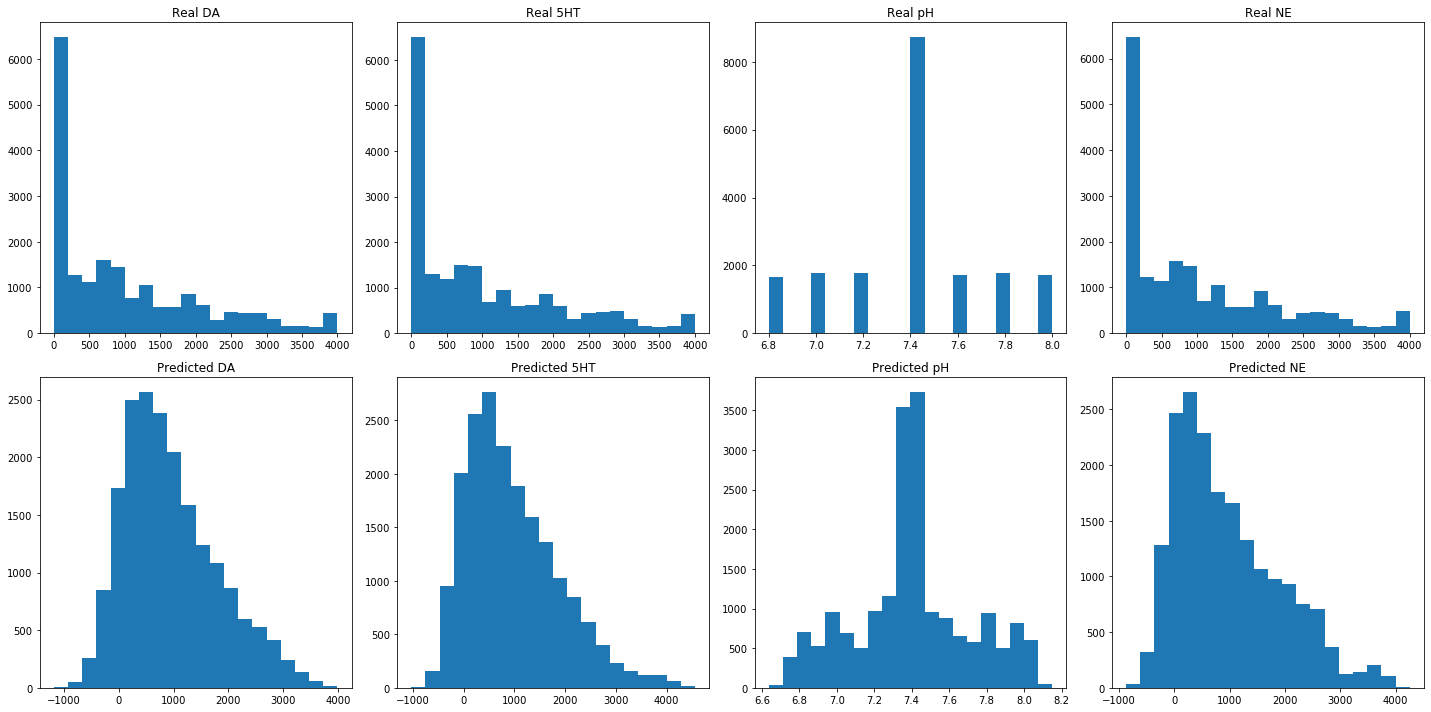

In [18]:
for a in fits:
    print(a)
    fit = fits[a]
    y_hat = cvglmnetPredict(fit, newx = x_val, s='lambda_min')
    print ('alpha %2.2f'%a, flush=True)
    plot_distributions(y_val, y_hat[:,:,0])
    for (error, name) in zip(np.mean(np.sqrt((y_hat[:,:,0]-y_val)**2),axis=0),names):
        print('%s: %4.5f'%(name,error), flush=True)

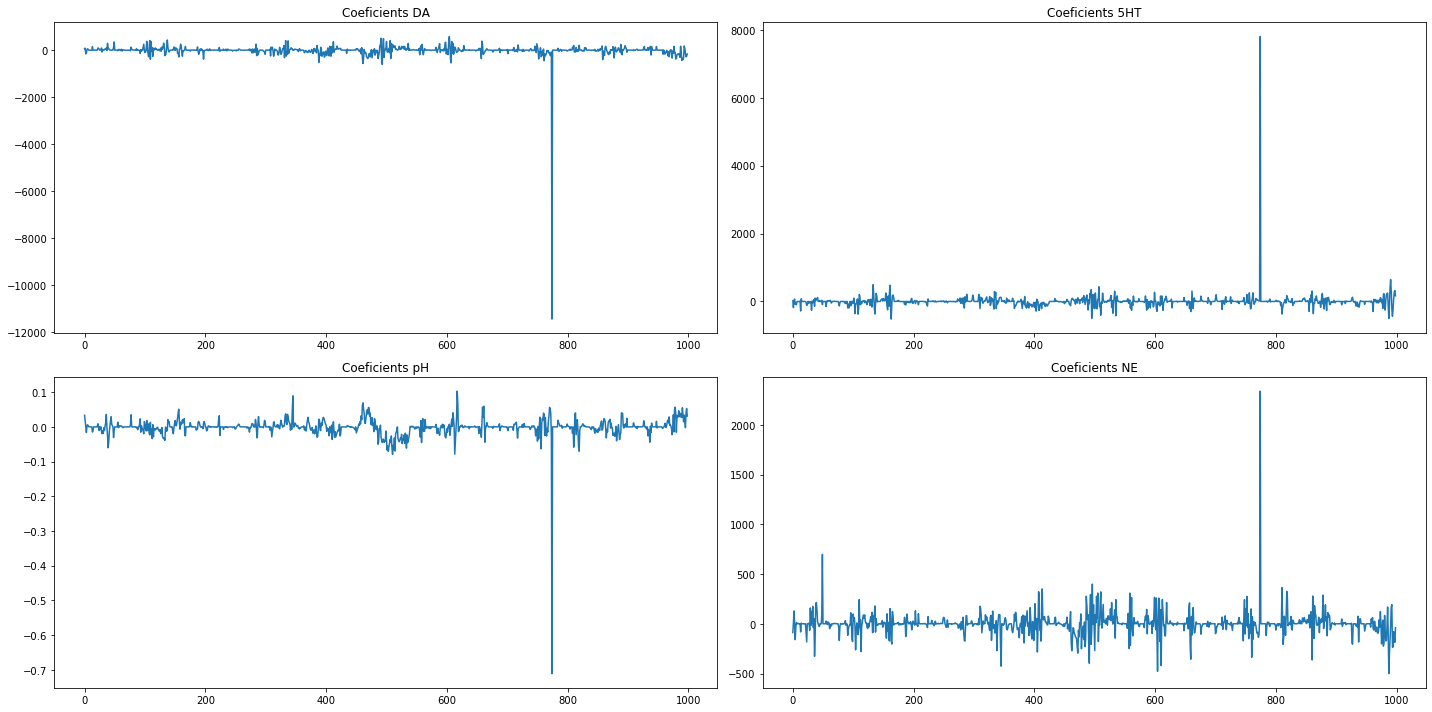

In [20]:
a = 1.
l = np.where([x == fits[a]['lambda_1se'][0] for x in fits[a]['lambdau']])[0][0]
fig, axs = plt.subplots(2, 2, sharey=False, sharex=False, tight_layout=True)
fig.set_size_inches(20,10)
for ia in range(4):
    idx = np.unravel_index(ia, axs.shape)
    x = fits[a]['glmnet_fit']['beta'][ia][:, l]
    axs[idx].plot(x)
    axs[idx].set_title("Coeficients %s"%names[ia])